# Notebook for viewing predictions/segmentations.  To view segmentations, first save segmentations by running evaluateFile.py with saveSegs=True

In [2]:
%matplotlib inline 
import os
import os.path as op
import matplotlib.cm as cm
import numpy as np
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib.pyplot as plt
import h5py
import array
from visualize_funcs import display_preds,display_seg,trim,formatAndSave
   
## Just to access the images...
data_folder = 'nobackup/turaga/data/fibsem_medulla_7col/tstvol-520-2-h5/'
os.chdir('/.')

#Open training data
f = h5py.File(data_folder + 'img_normalized.h5', 'r')
im = f['main']

#Open training labels
g = h5py.File(data_folder + 'groundtruth_aff.h5', 'r')
label_set = np.asarray(g['main'],dtype='float32') #3,z,y,x
label_set = np.transpose(label_set,(1,2,3,0))

## Viewing predictions

In [5]:
# preds
train_or_test='test' # if changed, also reload im,labels 
iteration = 50000
folder = 'ave' # 2 for fibsem 2, ave for average, ...
hdf5_pred_file = '/tier2/turaga/singhc/'+train_or_test+'/output_'+str(iteration)+'/tstvol-2_'+folder+'.h5'
hdf5_aff = h5py.File(hdf5_pred_file, 'r')
aff = np.asarray(hdf5_aff['main'],dtype='float32')

# transpose so they match image
aff = np.transpose(aff,(1,2,3,0))

im,label_set=trim(im,label_set,aff)

display_preds(im, label_set, aff, im_size=432, im2_size=432)

## Plotting F-Scores

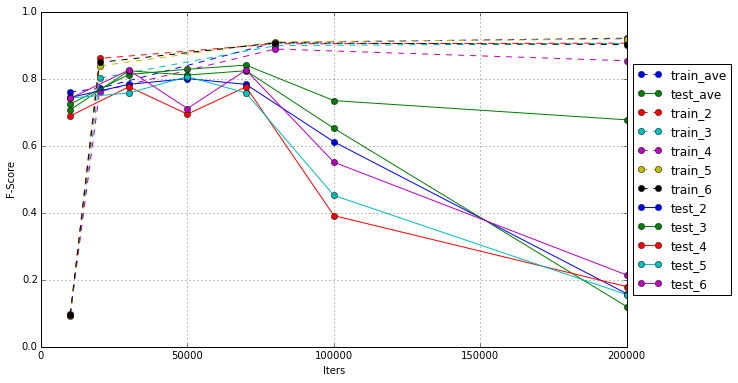

In [8]:
# folders to change, the two should correspond
train_or_tests = ['train']+['test']+['train']*5+['test']*5
fibsem_folders = ['ave']+['ave']+[str(i) for i in range(2,7)]+[str(i) for i in range(2,7)]

# calculated folders
N = len(fibsem_folders)
names = [train_or_tests[i]+'_'+fibsem_folders[i] for i in range(N)]
folders = ["/tier2/turaga/singhc/"+train_or_tests[i]+"/out/fibsem"+fibsem_folders[i]+"_" for i in range(N)]
output_file = '/tier2/turaga/singhc/figs/f_scores_full'
train = [10000,20000,80000,200000] # iterations calculated for train
test = [10000,30000,50000,70000,100000,200000] # iterations calculated for test
iters = [-1]*N*max(len(test),len(train))
for i in range(N):
    if train_or_tests[i]=='train':
        iters[i] = train 
    else: 
        iters[i] = test
dashed = [iters[i]==train for i in range(len(iters))]
all_target_folders = [folders[i]+str(iters[i][j]) for i in range(len(folders)) for j in range(len(iters[i]))]#["data_tier2/train/out/fibsem_ave_"+str(train[i]) for i in range(len(train))]
fig = plt.figure(figsize=(15,6))
ax = plt.subplot(111)
count = 0
for x in range(len(iters)):
    if(isinstance( iters[x],(int, long))):
        break
    target_folders =  all_target_folders[count:count+len(iters[x])]
    maxes = range(len(iters[x]))
    for i in range(len(target_folders)):
        outfolder = target_folders[i]
        a=np.fromfile( op.join(outfolder, 'square.dat') )
        data=a.reshape(len(a)/2,2)
        f_scores = range(data.shape[0])
        for j in range(len(f_scores)):
            f_scores[j]=2/(1/data[j][0]+1/data[j][1])
        maxes[i]=max(f_scores)
        count+=1
    if dashed[x]:
        plt.plot(iters[x],maxes, 'o--', label=names[x])
    else:
        plt.plot(iters[x],maxes, 'o-', label=names[x])
    plt.hold(True)
plt.xlabel('Iters')
plt.ylabel('F-Score')
formatAndSave(ax,output_file)

## Plotting Rand Curves

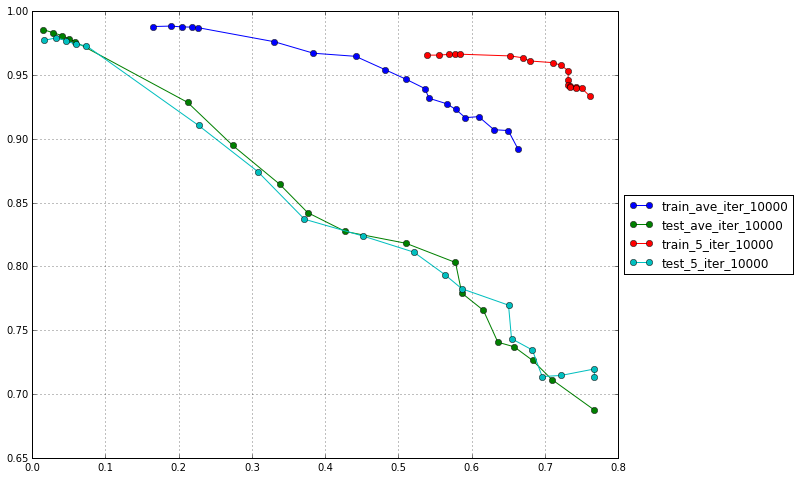

In [152]:
# folders to change, the two should correspond
train_or_tests = ['train']+['test']+['train']*1+['test']*1
fibsem_folders = ['ave']+['ave']+[str(i) for i in range(5,6)]+[str(i) for i in range(5,6)]
iters = [str(10000)]*4 # train has 20000,80000,200000, test has 10000,30000,50000,70000,100000,200000
output_file = "/tier2/turaga/singhc/figs/rand_test.png"

# calculated folders
N = len(fibsem_folders)
names = [train_or_tests[i]+'_'+fibsem_folders[i]+'_iter_'+iters[i] for i in range(N)]
folders = ["/tier2/turaga/singhc/"+train_or_tests[i]+"/out/fibsem"+fibsem_folders[i]+"_"+iters[i] for i in range(N)]

try:
    fig = plt.figure(figsize=(15,8))
    ax = plt.subplot(111)
    for i in range(len(folders)):
        outfolder = folders[i]
        try:
            a=np.fromfile( op.join(outfolder, 'square.dat') )
            data=a.reshape(len(a)/2,2)
            plt.plot( data[:,0], data[:,1], 'o-', label=names[i])
            plt.hold(True)
        except:
            continue
    formatAndSave(ax,output_file)
except:
    formatAndSave(ax,output_file)

## Viewing segmentations (currently gt - have to save them first)

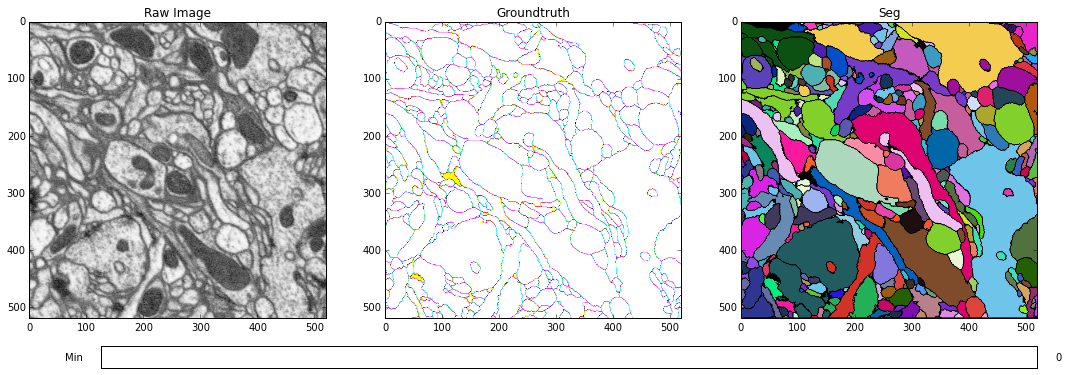

In [74]:
hdf5_seg_file = '/groups/turaga/home/turagas/data/FlyEM/fibsem_medulla_7col/tstvol-520-2-h5/groundtruth_seg_thick.h5'
#hdf5_seg_file = '/tier2/turaga/singhc/out/test_save_dat/square/1000.dat'
hdf5_seg = h5py.File(hdf5_seg_file, 'r')
seg = np.asarray(hdf5_seg['main'],dtype='uint32')

data_set,label_set=trim(im,label_set,seg)

display_seg(im, label_set, seg, im_size=520, im2_size=520)